In [10]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import matplotlib
import datetime
import pickle
import pandas as pd
import itertools
from scipy.stats import linregress
import seaborn as sns
sns.set('paper')
from scipy.stats import t

#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)


In [2]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$\mathrm{O}_2$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)
color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [35]:
def print_h(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m")
print_h('text', 43)

text


To adjust for autocorrelation, we will use the method of Bretherton et al 1999. 

## Single stressor extremes in the Canyons

us the pickles created for the correlation analysis as they are not separated by upw/dwn. 

In [17]:
def get_Trends(XX,Y):
     # 1. Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(XX, Y)
    #print('XX', XX)
    print(slope)
    print(intercept)
    # 2. Calculate residuals
    y_pred = intercept + slope * XX
    residuals = Y - y_pred
    
    # 3. Calculate lag-1 autocorrelation of residuals
    r1 = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    
    # 4. Calculate effective sample size
    Nt = len(Y)
    Ne = Nt * (1 - r1) / (1 + r1)
    
    # 5. Adjust standard error of the slope
    adjusted_std_err = std_err * np.sqrt(Nt / Ne)
    
    # Output results
    print(f"Slope (units/year): {3600.*24*365*slope}")
    print(f"Original Standard Error: {std_err}")
    print(f"Adjusted Standard Error: {adjusted_std_err}")
    print(f"Original p-value: {p_value}")
    
    # You can also recalculate the t-statistic and p-value using the adjusted standard error:
    
    # Calculate the t-statistic
    t_stat = slope / adjusted_std_err
    
    # Calculate the p-value based on the adjusted effective sample size (Ne)
    adjusted_p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=Ne-2))
    print(f"adjusted p-value: {adjusted_p_value}")
    alpha = 0.05 #confidence interval
    t_critical = t.ppf(1 - alpha/2, df=Ne - 2)

    # Compute confidence intervals based on the adjusted standard errors
    slope_ci = (3600.*24*365*(slope - t_critical * adjusted_std_err), 3600.*24*365*(slope + t_critical * adjusted_std_err))
    intercept_ci = (3600.*24*365*(intercept - t_critical * adjusted_std_err), 3600.*24*365*(intercept + t_critical * adjusted_std_err))
    print('slope_ci', slope_ci)
    return 3600.*24*365*slope, adjusted_p_value, slope_ci

In [20]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', idx, 'is significant')

O2
##################################
pickles/Upwelling_0_O2_corr.pickle
pickles/Downwelling_0_O2_corr.pickle
-6.812142389165855e-11
0.18331283745353305
Slope (units/year): -0.002148277223847344
Original Standard Error: 4.306536622798762e-12
Adjusted Standard Error: 6.844067300888468e-11
Original p-value: 1.3649051499882011e-55
adjusted p-value: 0.32688010252922095
slope_ci (-0.006540953171090434, 0.0022443987233957464)
OmegaA
##################################
pickles/Upwelling_0_OmegaA_corr.pickle
pickles/Downwelling_0_OmegaA_corr.pickle
-5.1335484526163e-11
0.16351150295831515
Slope (units/year): -0.0016189158400170764
Original Standard Error: 4.674844228058976e-12
Adjusted Standard Error: 1.141222343105924e-10
Original p-value: 7.145920791314447e-28
adjusted p-value: 0.660410026721439
slope_ci (-0.009412103294141806, 0.006174271614107654)
T
##################################
pickles/Upwelling_0_T_corr.pickle
pickles/Downwelling_0_T_corr.pickle
9.331570779202557e-11
-0.0133649990961

### Single stressor trends for the shallows

In [38]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', var)
        print_h(f'is significant',43)

O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle
4.588687207582118e-11
0.04578449738293055
Slope (units/year): 0.0014470883977830966
Original Standard Error: 6.798799645701548e-12
Adjusted Standard Error: 9.161175320550426e-11
Original p-value: 1.5803480844805546e-11
adjusted p-value: 0.6188267073907525
slope_ci (-0.004367356444125259, 0.007261533239691452)
OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle
1.2428958600330257e-10
-0.04778658361600943
Slope (units/year): 0.00391959638420015
Original Standard Error: 5.1528778556927734e-12
Adjusted Standard Error: 5.3109482712718807e-11
Original p-value: 1.637499294672022e-124
adjusted p-value: 0.021746688334206343
slope_ci (0.0005868476231331207, 0.007252345145267179)
 The trend for cluster  OmegaA
is significant
T
##################################
pickles/Upwelling_3_T_corr.pickle
pickles/Downwelling_3_T_c

#  Sngle stresor CLuster 1

In [53]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_1_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', var)
        print_h(f'is significant',43)

O2
##################################
pickles/Upwelling_1_O2_corr.pickle
pickles/Downwelling_1_O2_corr.pickle
1.1342530591710673e-11
0.08689857131817376
Slope (units/year): 0.0003576980447401878
Original Standard Error: 7.436385655915971e-12
Adjusted Standard Error: 9.260084668977846e-11
Original p-value: 0.12722668974811707
adjusted p-value: 0.9029625241247485
slope_ci (-0.005495763189877782, 0.006211159279358158)
OmegaA
##################################
pickles/Upwelling_1_OmegaA_corr.pickle
pickles/Downwelling_1_OmegaA_corr.pickle
2.7280113477616372e-11
0.06795890245012415
Slope (units/year): 0.0008603056586301099
Original Standard Error: 7.029062899622498e-12
Adjusted Standard Error: 8.94598753550273e-11
Original p-value: 0.00010477087993270775
adjusted p-value: 0.7616244700184462
slope_ci (-0.004800555176727561, 0.006521166493987781)
T
##################################
pickles/Upwelling_1_T_corr.pickle
pickles/Downwelling_1_T_corr.pickle
3.937547379328615e-11
0.05188840163871849

## single stressor cluster 2

In [54]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_2_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', var)
        print_h(f'is significant',43)

O2
##################################
pickles/Upwelling_2_O2_corr.pickle
pickles/Downwelling_2_O2_corr.pickle
-1.6100003221223643e-10
0.2978866062011849
Slope (units/year): -0.005077297015845088
Original Standard Error: 2.719369805906059e-12
Adjusted Standard Error: 7.810773248934128e-11
Original p-value: 0.0
adjusted p-value: 0.0706843796644645
slope_ci (-0.010686551225642455, 0.0005319571939522807)
OmegaA
##################################
pickles/Upwelling_2_OmegaA_corr.pickle
pickles/Downwelling_2_OmegaA_corr.pickle
-3.1311509831682774e-11
0.1419216939745745
Slope (units/year): -0.0009874397740519479
Original Standard Error: 3.1739335973073567e-12
Adjusted Standard Error: 7.188555163388286e-11
Original p-value: 7.746006597537918e-23
adjusted p-value: 0.6693121433544067
slope_ci (-0.005816920988574188, 0.003842041440470292)
T
##################################
pickles/Upwelling_2_T_corr.pickle
pickles/Downwelling_2_T_corr.pickle
5.040229085494433e-11
0.03895149231663714
Slope (units

## single stressor Cluster 4 

In [55]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_4_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', var)
        print_h(f'is significant',43)

O2
##################################
pickles/Upwelling_4_O2_corr.pickle
pickles/Downwelling_4_O2_corr.pickle
-1.7603070353956278e-11
0.12238011089211492
Slope (units/year): -0.0005551304266823651
Original Standard Error: 6.5173611959813085e-12
Adjusted Standard Error: 1.1496455764641503e-10
Original p-value: 0.006927453512972569
adjusted p-value: 0.8794801624887589
slope_ci (-0.008005115797449705, 0.006894854944084975)
OmegaA
##################################
pickles/Upwelling_4_OmegaA_corr.pickle
pickles/Downwelling_4_OmegaA_corr.pickle
2.4661207852066604e-12
0.09827646508428232
Slope (units/year): 7.777158508227725e-05
Original Standard Error: 6.466066412121597e-12
Adjusted Standard Error: 1.4198345036578593e-10
Original p-value: 0.7029199456735375
adjusted p-value: 0.9863545581680626
slope_ci (-0.009405695841988587, 0.00956123901215314)
T
##################################
pickles/Upwelling_4_T_corr.pickle
pickles/Downwelling_4_T_corr.pickle
7.167936550758119e-11
0.012064571385313

Single stressor Cluster 5

In [56]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_5_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da[var].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', var)
        print_h(f'is significant',43)

O2
##################################
pickles/Upwelling_5_O2_corr.pickle
pickles/Downwelling_5_O2_corr.pickle
-1.8561085106506106e-12
0.10297429623970623
Slope (units/year): -5.8534237991877655e-05
Original Standard Error: 6.757534755154862e-12
Adjusted Standard Error: 1.0343283368351425e-10
Original p-value: 0.7835743865713681
adjusted p-value: 0.9857833980469319
slope_ci (-0.006677676168582561, 0.006560607692598806)
OmegaA
##################################
pickles/Upwelling_5_OmegaA_corr.pickle
pickles/Downwelling_5_OmegaA_corr.pickle
1.633416346779672e-11
0.08130719581361667
Slope (units/year): 0.0005151141791204373
Original Standard Error: 6.773820637805366e-12
Adjusted Standard Error: 1.0994894452369221e-10
Original p-value: 0.015913306844571967
adjusted p-value: 0.8828536149842079
slope_ci (-0.006554094989210038, 0.007584323347450915)
T
##################################
pickles/Upwelling_5_T_corr.pickle
pickles/Downwelling_5_T_corr.pickle
4.261772468976368e-11
0.047339911356013

## Compound event trends for the canyons

There is an apparent linear trend in some of the triple extremes. Here, I test for significance. 



In [49]:
dual_extreme[0]

('O2', 'OmegaA')

-------------------------------------------------------------
-5.0300782761684894e-11
0.1473317901188867
Slope (units/year): -0.0015862854851724948
Original Standard Error: 3.968485016598013e-12
Adjusted Standard Error: 6.969065744271892e-11
Original p-value: 1.6978999119231517e-36
adjusted p-value: 0.4767731892216682
slope_ci (-0.006100320954400605, 0.0029277499840556155)
-------------------------------------------------------------
1.5921913483060783e-11
0.07117583164725119
Slope (units/year): 0.0005021134636018048
Original Standard Error: 6.789716072445905e-12
Adjusted Standard Error: 8.378346991752211e-11
Original p-value: 0.019049049054116196
adjusted p-value: 0.8499730746364909
slope_ci (-0.004791746433893238, 0.005795973361096847)
-------------------------------------------------------------
-4.4181067097155534e-11
0.11377520125630337
Slope (units/year): -0.001393294131975897
Original Standard Error: 2.041412035133968e-12
Adjusted Standard Error: 5.0626211826774035e-11
Original 

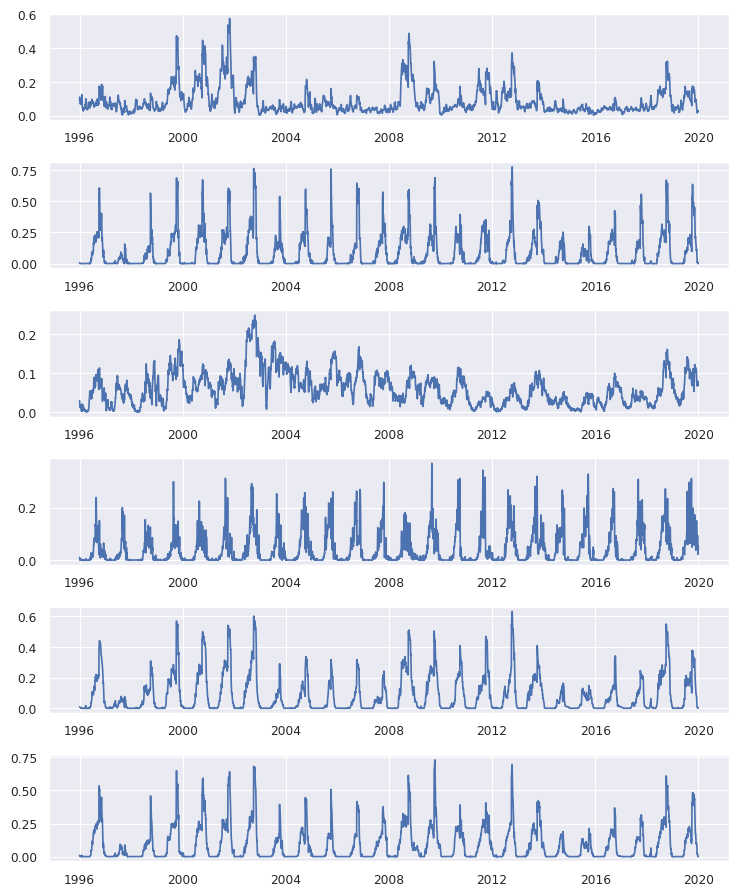

In [48]:
dual=0
figprops = dict(figsize=(Wf,Hf))
fig = plt.figure(**figprops)
for cluster_id in np.arange(6):
    var=dual_extreme[dual]
    ax = fig.add_subplot(6,1,cluster_id+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    print('-------------------------------------------------------------')
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', cluster_id ,' and variable ', dual_extreme[dual][0]+dual_extreme[dual][1]);print_h( f'is significant',43)
        plt.plot(X,Y, 'r')
    else:
        plt.plot(X,Y)
plt.tight_layout()

In [50]:
dual_extreme[1]

('O2', 'T')

-------------------------------------------------------------
1.7325312388088334e-12
-0.0003358467257763428
Slope (units/year): 5.463710514707537e-05
Original Standard Error: 1.739391119212715e-13
Adjusted Standard Error: 1.8621280348291872e-12
Original p-value: 3.0134532189279824e-23
adjusted p-value: 0.35516770498352024
slope_ci (-6.236049692987602e-05, 0.00017163470722402678)
-------------------------------------------------------------
5.393067948083937e-12
-0.004961512120593182
Slope (units/year): 0.00017007579081077505
Original Standard Error: 2.781972407180359e-13
Adjusted Standard Error: 2.2280056659758095e-12
Original p-value: 5.2229951948056984e-82
adjusted p-value: 0.016828682348261292
slope_ci (3.1115335763466966e-05, 0.0003090362458580831)
 The trend for cluster  1  and variable  O2T
is significant
-------------------------------------------------------------
3.3411784449672255e-14
-6.835923846531744e-06
Slope (units/year): 1.0536740344048642e-06
Original Standard Error: 8

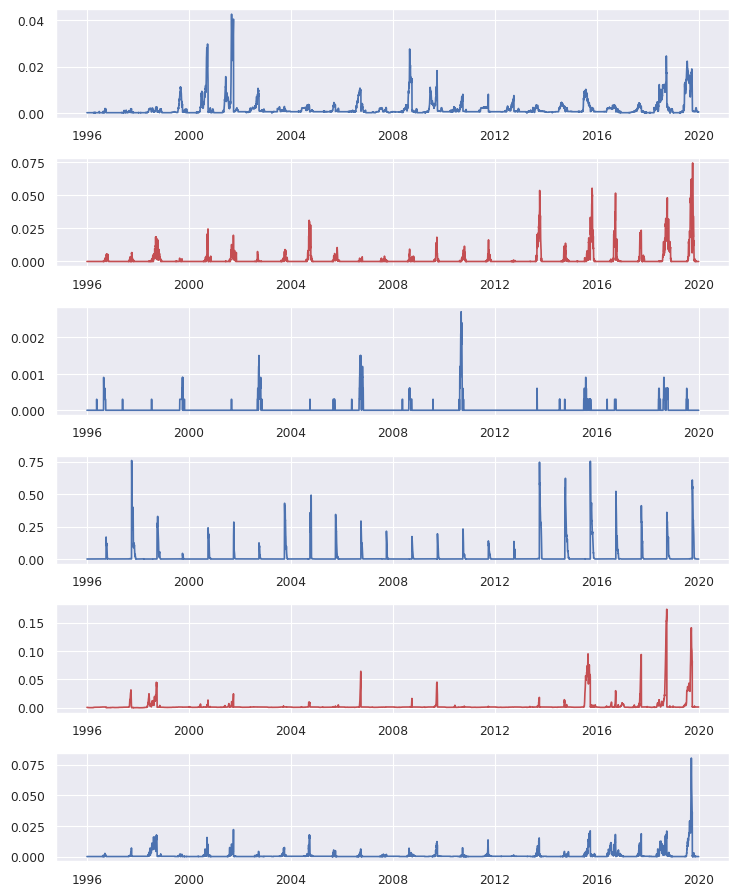

In [47]:
dual=1
figprops = dict(figsize=(Wf,Hf))
fig = plt.figure(**figprops)
for cluster_id in np.arange(6):
    var=dual_extreme[dual]
    ax = fig.add_subplot(6,1,cluster_id+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    print('-------------------------------------------------------------')
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', cluster_id ,' and variable ', dual_extreme[dual][0]+dual_extreme[dual][1]);print_h( f'is significant',43)
        plt.plot(X,Y, 'r')
    else:
        plt.plot(X,Y)
plt.tight_layout()

In [51]:
dual_extreme[2]

('OmegaA', 'T')

-------------------------------------------------------------
4.7756813352299366e-12
-0.001939690753447164
Slope (units/year): 0.00015060588658781128
Original Standard Error: 3.810866918668722e-13
Adjusted Standard Error: 3.979679693657493e-12
Original p-value: 1.0119966449124236e-35
adjusted p-value: 0.23374751013700035
slope_ci (-9.923262612148471e-05, 0.0004004443992971073)
-------------------------------------------------------------
5.5707214238976755e-12
-0.005100999657036947
Slope (units/year): 0.0001756782708240371
Original Standard Error: 2.7273571168511684e-13
Adjusted Standard Error: 2.2117833507364904e-12
Original p-value: 1.2540161243927677e-90
adjusted p-value: 0.012981103355486301
slope_ci (3.7697400033959505e-05, 0.00031365914161411474)
 The trend for cluster  1  and variable  OmegaAT
is significant
-------------------------------------------------------------
1.6669657647965113e-13
-8.56793205212074e-05
Slope (units/year): 5.256943235862278e-06
Original Standard Error:

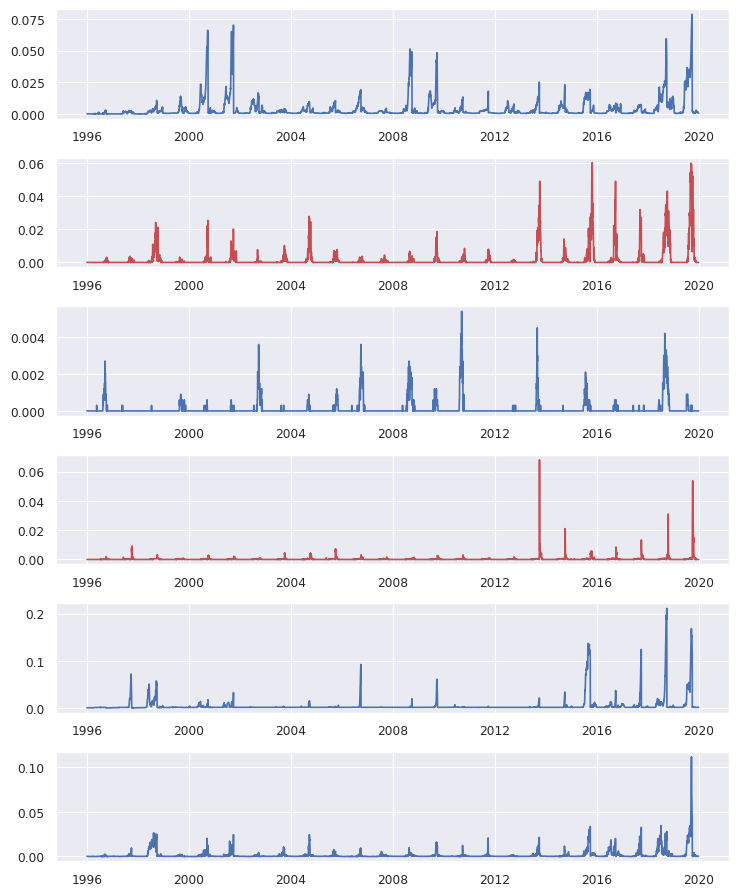

In [46]:
dual=2
figprops = dict(figsize=(Wf,Hf))
fig = plt.figure(**figprops)
for cluster_id in np.arange(6):
    var=dual_extreme[dual]
    ax = fig.add_subplot(6,1,cluster_id+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    print('-------------------------------------------------------------')
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', cluster_id ,' and variable ', dual_extreme[dual][0]+dual_extreme[dual][1]);print_h( f'is significant',43)
        plt.plot(X,Y, 'r')
    else:
        plt.plot(X,Y)
plt.tight_layout()

In [52]:
dual_extreme[3]

('T', 'O2', 'OmegaA')

-------------------------------------------------------------
1.7527843900297871e-12
-0.0003935670633706588
Slope (units/year): 5.527580852397937e-05
Original Standard Error: 1.7259456107527566e-13
Adjusted Standard Error: 1.8434489016886193e-12
Original p-value: 4.256883285614364e-24
adjusted p-value: 0.34475731308185686
slope_ci (-6.05390901606917e-05, 0.00017109070720865044)
-------------------------------------------------------------
4.70897714106404e-12
-0.004383669159858938
Slope (units/year): 0.00014850230312059555
Original Standard Error: 2.374993084149379e-13
Adjusted Standard Error: 1.8696488407398346e-12
Original p-value: 1.2785718865496095e-85
adjusted p-value: 0.012910089543202607
slope_ci (3.192875193323293e-05, 0.0002650758543079582)
 The trend for cluster  1  and variable  TO2
is significant
-------------------------------------------------------------
3.279315892417948e-14
-1.349369849156804e-05
Slope (units/year): 1.034165059832924e-06
Original Standard Error: 6.3230

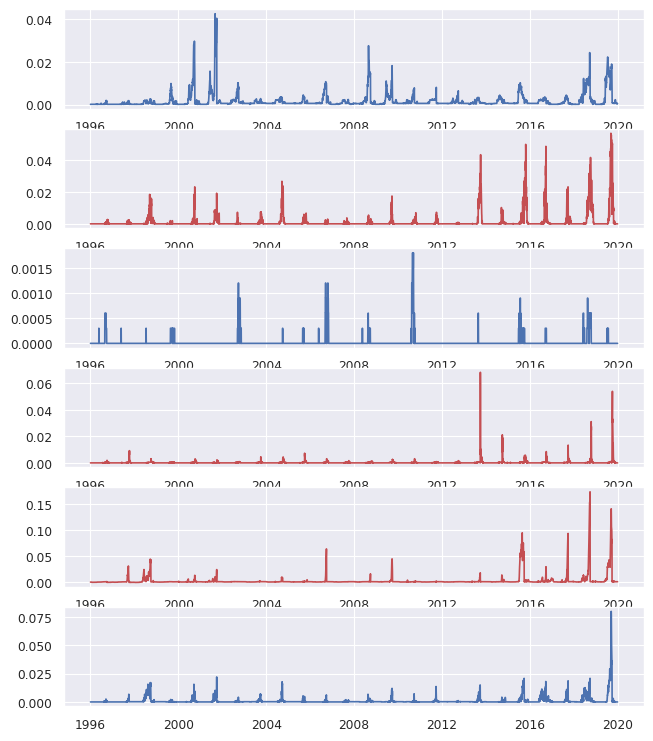

In [45]:
dual=3
figprops = dict(figsize=(Wf,Hf))
fig = plt.figure(**figprops)
for cluster_id in np.arange(6):
    var=dual_extreme[dual]
    ax = fig.add_subplot(6,1,cluster_id+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #print('X,Y',X, Y)
    XX=np.array([x.astype('datetime64[s]').astype('int') for x in X])
    print('-------------------------------------------------------------')
    slope, p_val, CI=get_Trends(XX,Y)
    if p_val<0.05:
        print(' The trend for cluster ', cluster_id ,' and variable ', dual_extreme[dual][0]+dual_extreme[dual][1]);print_h( f'is significant',43)
        plt.plot(X,Y, 'r')
    else:
        plt.plot(X,Y)



In [21]:
type(XX)

list